# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [121]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [122]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns

In [123]:
# import sys
# !{sys.executable} -m pip install pygam


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [124]:
#your code here
cal_train = pd.read_csv("data/calendar_train.csv", parse_dates = ['date'])
cal_test = pd.read_csv("data/calendar_test.csv", parse_dates = ['date'])

print(cal_train.dtypes)
cal_train['Month'] = cal_train['date'].dt.month
cal_train['Day'] = cal_train['date'].dt.dayofweek

cal_test['Month'] = cal_test['date'].dt.month
cal_test['Day'] = cal_test['date'].dt.dayofweek

listing_id             int64
date          datetime64[ns]
available             object
price                float64
dtype: object


In [125]:
cal_train.dropna(inplace=True)
cal_test.dropna(inplace=True)

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [126]:
avg_price_month = cal_train.groupby(['Month'], as_index=False).agg({'price': 'mean'})
avg_price_day = cal_train.groupby(['Day'], as_index=False).agg({'price':'mean'})
avg_price_month.describe()

,Month,price
count,12.000000,12.000000
mean,6.500000,245.243108
std,3.605551,40.060676
min,1.000000,185.940598
25%,3.750000,213.104590
50%,6.500000,267.813791
75%,9.250000,277.011655
max,12.000000,288.174429


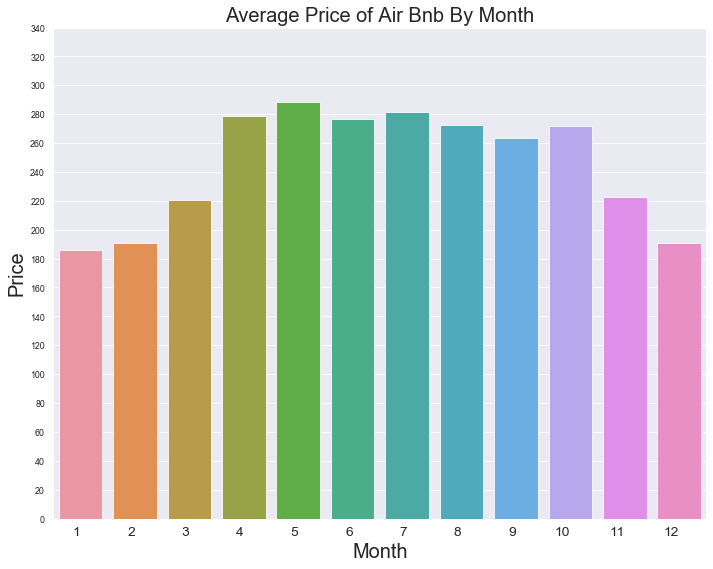

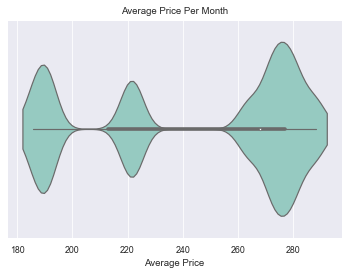

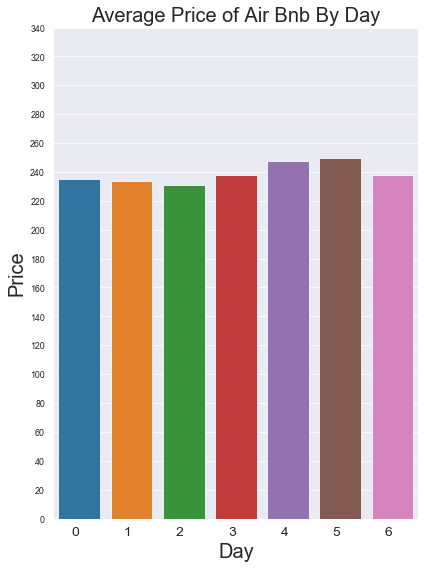

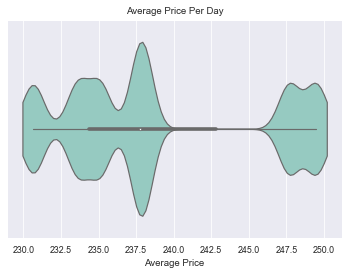

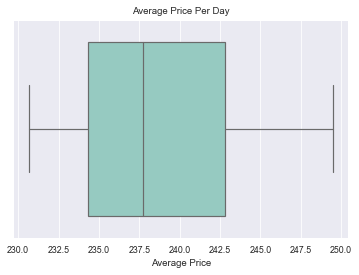

In [127]:
#Plotting the average price of AirBnbs by month
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.set_context("paper")
chart2 = sns.barplot(x = 'Month', y='price', data = avg_price_month)
plt.title('Average Price of Air Bnb By Month', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
chart2.set_xticklabels(
    chart2.get_xticklabels(),
    rotation=0,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'x-large'
)
plt.yticks(np.arange(0, 350, 20))
plt.tight_layout(h_pad = 0.4)
plt.show()

# plot2 = avg_price_month.plot.bar(x = "Month", y= 'price', color='Teal', title='Average Price per Month')
# _ = plot2.set_xlabel("Month")
# _ = plot2.set_ylabel("Price")
# plt.ylim(100,350)
# plt.show()

# Plotting distribution of prices in training dataset. We see the majority of prices hover in the range of $190 to $300. 
#There's an outlier at $6000
plot3 = sns.violinplot(avg_price_month.price, palette = 'Set3', bw=0.1, cut = 1)
plt.title("Average Price Per Month")
plt.xlabel('Average Price')
plt.show()


# plot4 = avg_price_day.plot.bar(x = "Day", y= 'price', color='Red', title='Average Price per Day')
# _ = plot4.set_xlabel("Day")
# _ = plot4.set_ylabel("Price")
# plt.ylim(200,350)
# plt.show()

plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
sns.set_context("paper")
chart2 = sns.barplot(x = 'Day', y='price', data = avg_price_day)
plt.title('Average Price of Air Bnb By Day', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.xlabel('Day', fontsize = 20)
chart2.set_xticklabels(
    chart2.get_xticklabels(),
    rotation=0,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'x-large'
)
plt.yticks(np.arange(0, 350, 20))
plt.tight_layout(h_pad = 0.4)
plt.show()

plot5 = sns.violinplot(avg_price_day.price, palette = 'Set3', bw=0.1, cut = 1)
plt.title("Average Price Per Day")
plt.xlabel('Average Price')
plt.show()

plot6 = sns.boxplot(avg_price_day.price, palette = 'Set3')
plt.title("Average Price Per Day")
plt.xlabel('Average Price')
plt.show()


First I will discuss the plot shwoing average price by day, then I will dicuss the average price by month. 

Unsurprisingly, there seems to be no relationship between AirBnb's prices and the day of the week. In the above plot, we see that the average price per day sits in the range of $\$230$ to $\$250$, with the median of prices at approximately $\$237.5$.

Contrastingly, we see more fluctuation in AirBnb's prices when we consider the month. We seem from the above plots, that the range of average prices ranges from $\$185.94$ to $\$288.17$. Furthermore, by examining the violin plot, we see that average prices cluster into three groups: around $\$190$, $\$220$, and $\$270$. Further analysis is needed to understand this interesting behavior. 

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [128]:
#your code here
#Converting Date Column
from datetime import datetime
date_min = min(cal_train.date)
date_mintest = min(cal_test.date)

cal_train['date_new'] = cal_train.apply(lambda row:((row['date'] - date_min).days), axis=1)
avg_price_daily= cal_train.groupby(['date_new'], as_index=False).agg({'price':'mean'})

cal_test['date_new'] = cal_test.apply(lambda row:((row['date'] - date_mintest).days), axis=1)
avg_price_daily_test= cal_test.groupby(['date_new'], as_index=False).agg({'price':'mean'})

In [129]:
xpred = pd.DataFrame({"date_new":np.arange(1,366,1)})
xpred

,date_new
0,1
1,2
2,3
3,4
4,5
...,...
360,361
361,362
362,363
363,364


### 1. Polynomials

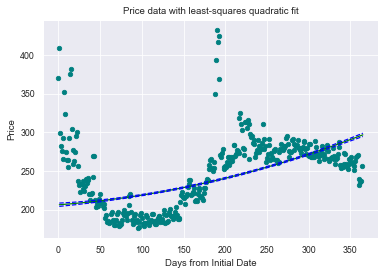

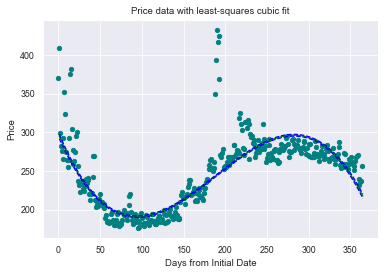

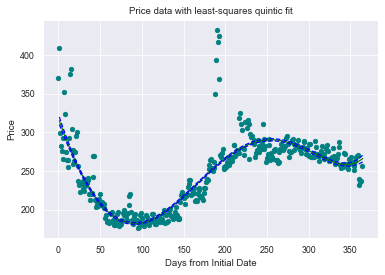

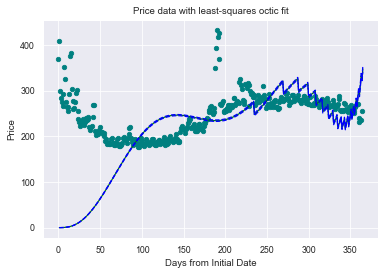

In [140]:
#your code here
#Polynomial Degrees 2
model1 = sm.ols(formula = 'price ~ np.vander(date_new,3, increasing=True)-1', data = cal_train).fit()
poly_predictions = model1.get_prediction(xpred).summary_frame()
poly_predictions_train = model1.get_prediction(cal_train).summary_frame()


##On test data
model1test = sm.ols(formula = 'price ~ np.vander(date_new,3, increasing=True)-1', data = cal_test).fit()
poly_predictionstest = model1test.get_prediction(xpred).summary_frame()
poly_predictions_test = model1test.get_prediction(cal_test).summary_frame()


# Polynomial Degree 3
model2 = sm.ols(formula = 'price ~ np.vander(date_new,4, increasing=True)-1', data = cal_train).fit()
poly_predictions2 = model2.get_prediction(xpred).summary_frame()
poly_predictions2_train = model2.get_prediction(cal_train).summary_frame()


##On test data
model2test = sm.ols(formula = 'price ~ np.vander(date_new,4, increasing=True)-1', data = cal_test).fit()
poly_predictions2test = model2test.get_prediction(xpred).summary_frame()
poly_predictions2_test = model2test.get_prediction(cal_test).summary_frame()


#polynomial Degree 5
model3 = sm.ols(formula = 'price ~ np.vander(date_new,6, increasing=True)-1', data = cal_train).fit()
poly_predictions3 = model3.get_prediction(xpred).summary_frame()
poly_predictions3_train = model3.get_prediction(cal_train).summary_frame()


##On test data
model3test = sm.ols(formula = 'price ~ np.vander(date_new,6, increasing=True)-1', data = cal_test).fit()
poly_predictions3test = model3test.get_prediction(xpred).summary_frame()
poly_predictions3_test = model3test.get_prediction(cal_test).summary_frame()


#Polynomial Degree 8
model4 = sm.ols(formula = 'price ~ np.vander(date_new,9, increasing=True)-1', data = cal_train).fit()
poly_predictions4 = model4.get_prediction(xpred).summary_frame()
poly_predictions4_train = model4.get_prediction(cal_train).summary_frame()


##On test data
model4test = sm.ols(formula = 'price ~ np.vander(date_new,9, increasing=True)-1', data = cal_test).fit()
poly_predictions4test = model4test.get_prediction(xpred).summary_frame()
poly_predictions4_test = model4test.get_prediction(cal_test).summary_frame()


# poly_predictions.head()
#Plots for Degree 2
plot_poly1 = avg_price_daily.plot.scatter(x='date_new',y='price',c='Teal',title="Price data with least-squares quadratic fit")
plot_poly1.set_xlabel("Days from Initial Date")
plot_poly1.set_ylabel("Price")

plot_poly1.plot(xpred, poly_predictions['mean'],color="green")
plot_poly1.plot(xpred, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
plot_poly1.plot(xpred, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

#Plots for Degree 3
plot_poly2 = avg_price_daily.plot.scatter(x='date_new',y='price',c='Teal',title="Price data with least-squares cubic fit")
plot_poly2.set_xlabel("Days from Initial Date")
plot_poly2.set_ylabel("Price")

plot_poly2.plot(xpred, poly_predictions2['mean'],color="green")
plot_poly2.plot(xpred, poly_predictions2['mean_ci_lower'], color="blue",linestyle="dashed")
plot_poly2.plot(xpred, poly_predictions2['mean_ci_upper'], color="blue",linestyle="dashed");

#Plots for Degree 5
plot_poly3 = avg_price_daily.plot.scatter(x='date_new',y='price',c='Teal',title="Price data with least-squares quintic fit")
plot_poly3.set_xlabel("Days from Initial Date")
plot_poly3.set_ylabel("Price")

plot_poly3.plot(xpred, poly_predictions3['mean'],color="green")
plot_poly3.plot(xpred, poly_predictions3['mean_ci_lower'], color="blue",linestyle="dashed")
plot_poly3.plot(xpred, poly_predictions3['mean_ci_upper'], color="blue",linestyle="dashed");

#Plots for Degree 8
plot_poly4 = avg_price_daily.plot.scatter(x='date_new',y='price',c='Teal',title="Price data with least-squares octic fit")
plot_poly4.set_xlabel("Days from Initial Date")
plot_poly4.set_ylabel("Price")

plot_poly4.plot(xpred, poly_predictions4['mean'],color="green")
plot_poly4.plot(xpred, poly_predictions4['mean_ci_lower'], color="blue",linestyle="dashed")
plot_poly4.plot(xpred, poly_predictions4['mean_ci_upper'], color="blue",linestyle="dashed");


In [141]:
#R2 Scores for Each Model on Training and Test Data
train_model = sm.ols('price~date_new',data=cal_train)
fit1 = train_model.fit()
pred1 = fit1.predict(cal_train.date_new)
print(cal_train.price.shape)
print(poly_predictions_train.shape)
print(cal_test.shape)
print(poly_predictionstest.shape)
poly_predictions_test
cal_test.price

(309288,)
(309288, 6)
(133100, 7)
(365, 6)


0         138.0
1         210.0
12        869.0
14        239.0
17        259.0
          ...  
314566    250.0
314567     85.0
314568    199.0
314570    188.0
314571     40.0
Name: price, Length: 133100, dtype: float64

In [142]:
train_modeltest = sm.ols('price~date_new',data=cal_test)
fit1test = train_modeltest.fit()
pred1test = fit1test.predict(cal_test.date_new)

In [143]:
print("R^2 score for training data on Quadratic Model:", r2_score(cal_train.price, poly_predictions_train['mean']))
print("R^2 score for test data on Quadratic Model:",r2_score(cal_test.price, poly_predictions_test['mean']))


print("R^2 score for training data on Cubic Model:",r2_score(cal_train.price, poly_predictions2_train['mean']))
print("R^2 score for test data on Cubic Model:",r2_score(cal_test.price, poly_predictions2_test['mean']))


print("R^2 score for training data on Quintic Model:",r2_score(cal_train.price, poly_predictions3_train['mean']))
print("R^2 score for test data on Quintic Model:",r2_score(cal_test.price, poly_predictions3_test['mean']))


print("R^2 score for training data on Octic Model:",r2_score(cal_train.price, poly_predictions4_train['mean']))
print("R^2 score for test data on Octic Model:",r2_score(cal_test.price, poly_predictions4_test['mean']))

R^2 score for training data on Quadratic Model: 0.018488573687428622
R^2 score for test data on Quadratic Model: 0.019264151360562587
R^2 score for training data on Cubic Model: 0.03893294505042644
R^2 score for test data on Cubic Model: 0.03882714270563992
R^2 score for training data on Quintic Model: 0.04210025470809475
R^2 score for test data on Quintic Model: 0.04181248363043144
R^2 score for training data on Octic Model: -0.17019480710237755
R^2 score for test data on Octic Model: -0.1579304861526014


In [144]:
#0.04 R2 is correct answer
# train_model = sm.ols('price~date_new',data=avg_price_daily)
# fit1 = train_model.fit()
# pred1 = fit1.predict(avg_price_daily.date_new)

# train_modeltest = sm.ols('price~date_new',data=avg_price_daily_test)
# fit1test = train_modeltest.fit()
# pred1test = fit1test.predict(avg_price_daily_test.date_new)

# print("R^2 score for full training data :", r2_score(avg_price_daily.price,pred1))
# print("R^2 score for full test data :", r2_score(avg_price_daily_test.price,pred1test))

# print("R^2 score for training data on Quadratic Model:", r2_score(avg_price_daily.price, poly_predictions['mean']))
# print("R^2 score for test data on Quadratic Model:",r2_score(avg_price_daily.price, poly_predictionstest['mean']))


# print("R^2 score for training data on Cubic Model:",r2_score(avg_price_daily.price, poly_predictions2['mean']))
# print("R^2 score for test data on Cubic Model:",r2_score(avg_price_daily.price, poly_predictions2test['mean']))


# print("R^2 score for training data on Quintic Model:",r2_score(avg_price_daily.price, poly_predictions3['mean']))
# print("R^2 score for test data on Quintic Model:",r2_score(avg_price_daily.price, poly_predictions3test['mean']))


# print("R^2 score for training data on Octic Model:",r2_score(avg_price_daily.price, poly_predictions4['mean']))
# print("R^2 score for test data on Octic Model:",r2_score(avg_price_daily.price, poly_predictions4test['mean']))


# print("R^2 score for full training data :", r2_score(cal_train.price,pred1))
# print("R^2 score for full test data :", r2_score(cal_test.price,pred1test))

_your answer here_


### 2. Degree 8 oddity


This may be a case of ill-conditioning. Let $X$ be the matrix of observed data. We find that as the order of a polynomial regression increases, the $X'X$ matrix becomes ill-conditioned. It is possible that this ill-conditioning introduces multicollinearity in the columns of the $X$ matrix.

Source: http://home.iitk.ac.in/~shalab/regression/Chapter12-Regression-PolynomialRegression.pdf

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

Fit a Smoothing spline model in pygam with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

In [147]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import r2_score

# lam= np.logspace(-10,10,21)
# kf = KFold(n_splits=21, random_state=47, shuffle=True)
# scores = np.zeros((21,len(lam)))

# for i, (train_index, test_index) in enumerate(kf.split(avg_price_daily)):
#     train_df = avg_price_daily.iloc[train_index,:]
#     #test_df = sorted_noisy_diab.iloc[test_index,:]
#     for j,cur_smoothing in enumerate(lam):
#         gam = LinearGAM(lam = cur_smoothing, n_splines=25).fit(train_df.date_new,train_df.price)
        
#         scores[i,j] = r2_score(train_df['price'], gam.predict(train_df['date_new']))
        
# np.mean(scores, axis=0)
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

lam= np.logspace(-3,2,6)
kf = KFold(n_splits=6, random_state=47, shuffle=True)
scores = np.zeros((6,len(lam)))

for i, (train_index, test_index) in enumerate(kf.split(cal_train)):
    train_df = cal_train.iloc[train_index,:]
    #test_df = sorted_noisy_diab.iloc[test_index,:]
    for j,cur_smoothing in enumerate(lam):
        gam = LinearGAM(lam = cur_smoothing, n_splines=25).fit(train_df.date_new,train_df.price)
        
        scores[i,j] = r2_score(train_df['price'], gam.predict(train_df['date_new']))
        
np.mean(scores, axis=0)

array([0.04509546, 0.04509546, 0.04509536, 0.04509014, 0.04504325,
       0.04475018])

In [148]:
best_s = lam[np.argmax(np.mean(scores, axis=0))]
best_s

0.001

In [149]:
for i, (train_index, test_index) in enumerate(kf.split(cal_test)):
#     train_df = avg_price_daily.iloc[train_index,:]
    test_df = cal_test.iloc[test_index,:]
    for j,cur_smoothing in enumerate(lam):
        gam = LinearGAM(lam = cur_smoothing, n_splines=25).fit(train_df.date_new,train_df.price)
        
        scores[i,j] = r2_score(train_df['price'], gam.predict(train_df['date_new']))
        
np.mean(scores, axis=0)

array([0.044585  , 0.04458499, 0.04458493, 0.04458168, 0.04454687,
       0.04425913])

In [150]:
best_s_test = lam[np.argmax(np.mean(scores, axis=0))]
best_s_test

0.001

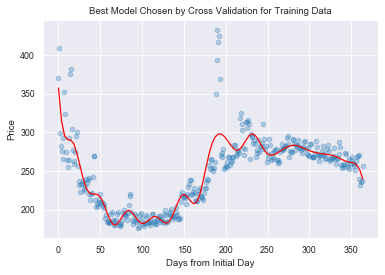

In [155]:
# Best Model for Training Data
X = avg_price_daily.date_new
Y = avg_price_daily.price
gam = LinearGAM( lam = best_s, n_splines=25).fit(X,Y)
XX=gam.generate_X_grid(term=0)
plt.scatter(X,Y,alpha=0.3);
plt.title('Best Model Chosen by Cross Validation for Training Data')
plt.ylabel("Price")
plt.xlabel('Days from Initial Day')
plt.plot(XX,gam.predict(XX), color='red')
        

1e-05


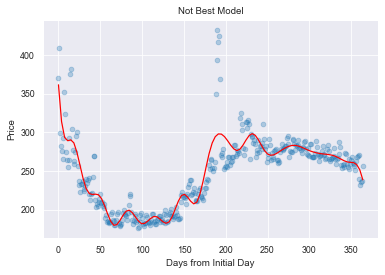

0


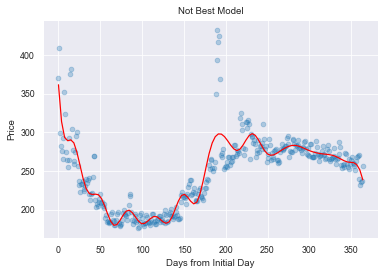

10


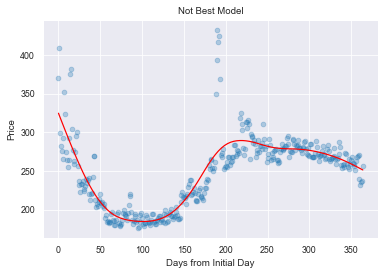

100.0


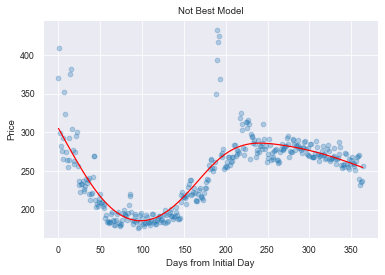

100000.0


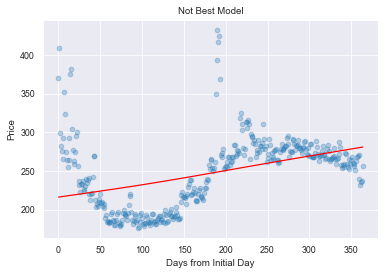

In [156]:
messy_lams= [1e-5,0,10,1e2,1e5]
for i in messy_lams:
    X = avg_price_daily.date_new
    Y = avg_price_daily.price
    gam = LinearGAM( lam = i, n_splines=25).fit(X,Y)
    XX=gam.generate_X_grid(term=0)
    print(i)
    plt.figure()
    plt.scatter(X,Y,alpha=0.3);
    plt.title('Not Best Model')
    plt.ylabel("Price")
    plt.xlabel('Days from Initial Day')
    plt.plot(XX,gam.predict(XX), color='red')
    plt.show()

0.04495425193601077


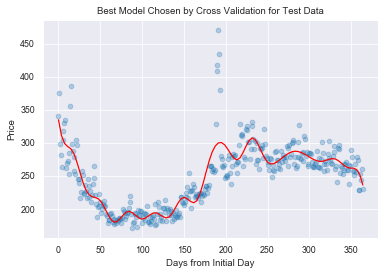

In [161]:
#Best model for Test Data
X_test = avg_price_daily_test.date_new
Y_test = avg_price_daily_test.price
gam_test = LinearGAM( lam = best_s_test, n_splines=25).fit(X_test,Y_test)
XX_test=gam_test.generate_X_grid(term=0)
plt.scatter(X_test,Y_test,alpha=0.3);
plt.plot(XX_test,gam_test.predict(XX_test), color='red')
plt.title('Best Model Chosen by Cross Validation for Test Data')
plt.ylabel("Price")
plt.xlabel('Days from Initial Day')

gam_testr2 = LinearGAM( lam = best_s_test, n_splines=25).fit(cal_test.date_new,cal_test.price)
print(r2_score(cal_test.price,gam_testr2.predict(cal_test.date_new)))

In [ ]:
messy_lams= [1e-5,0,10,1e2,1e5]
for i in messy_lams:
    X = avg_price_daily_test.date_new
    Y = avg_price_daily_test.price
    gam = LinearGAM( lam = i, n_splines=25).fit(X,Y)
    XX=gam.generate_X_grid(term=0)
    print(i)
    plt.figure()
    plt.scatter(X,Y,alpha=0.3);
    plt.title('Not Best Model')
    plt.ylabel("Price")
    plt.xlabel('Days from Initial Day')
    plt.plot(XX,gam.predict(XX), color='red')
    plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# #parameters= {'lam' :[0,1e3], 'n_splines':[0,50]}
# # lam= np.logspace(-3,11,11)
# # lams = np.array([lam]) 
# X = avg_price_daily.date_new
# Y = avg_price_daily.price

# gam = LinearGAM(n_splines=25).fit(X,Y)
# XX=gam.generate_X_grid(term=0)
# lam = gam.lam
# gam.gridsearch(X,Y,lam=lam)
# # gam.summary()
# # plt.scatter(X,Y,alpha=0.3);
# # plt.plot(XX,gam.predict(XX))

In [ ]:
gam = LinearGAM()
gam.gridsearch(X,y)

### 4. Effects of parameters
Using the Linear General Additive Model maximized the R^2 value.

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [ ]:
cal_train['weekend'] = 1*(cal_train['Day']==4)| 1*(cal_train['Day']==5)
cal_train.head(10)

In [168]:
X = cal_train.date_new
Y = cal_train.price
gam = LinearGAM(lam = best_s, n_splines=25).fit(X,Y)
XX=gam.generate_X_grid(term=0)
plt.scatter(X,Y,alpha=0.3);
plt.title('Best Model Chosen by Cross Validation for Training Data')
plt.ylabel("Price")
plt.xlabel('Days from Initial Day')
plt.plot(XX,gam.predict(XX), color='red')

,listing_id,date,available,price,Month,Day,date_new,weekend
123,20872145,2018-04-02,t,62.0,4,0,178,0
124,20872145,2018-04-01,t,59.0,4,6,177,0
125,20872145,2018-03-31,t,75.0,3,5,176,1
126,20872145,2018-03-30,t,71.0,3,4,175,1
127,20872145,2018-03-28,t,51.0,3,2,173,0
128,20872145,2018-03-24,t,46.0,3,5,169,1
129,20872145,2018-03-20,t,45.0,3,1,165,0
130,20872145,2018-03-19,t,45.0,3,0,164,0
131,20872145,2018-03-18,t,45.0,3,6,163,0
132,20872145,2018-03-17,t,47.0,3,5,162,1


### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [3]:
#your code here


_your answer here_

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [21]:
#your code here

_your answer here_

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [26]:
#your code here

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_


In [31]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here

f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)


In [4]:
#your code here

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

_your answer here_